# **TrasCan segmentation project**

In this project, we demonstrate a comprehensive approach to tackling marine pollution by developing a deep learning model capable of identifying and categorizing different types of debris found in oceanic environments. Using the TrashCan dataset, which contains underwater images along with COCO-format annotations, we first preprocessed the data to create binary masks for objects in the images. We then trained a U-Net based model to detect these objects, focusing on marine debris, animals, plants, and parts of the remotely operated vehicle (ROV) used to capture the images. The final step involved evaluating the model's performance in accurately identifying and segmenting these objects within the underwater images. This project not only showcases the potential of deep learning in environmental conservation efforts but also provides a practical tool for identifying and addressing the issue of oceanic debris.

Authors: Victoria Wahlig and Ricardo A. Gonzales

<p align="center">
    <a href="https://conservancy.umn.edu/handle/11299/214865">
        <img src="https://conservancy.umn.edu/bitstream/handle/11299/214865/trash_can_thumbnail.jpg?sequence=8&isAllowed=y"/>
    </a>
</p>

# Step 1: Data Preprocessing for TrashCan Dataset

This section contains code for preprocessing the TrashCan dataset for use in machine learning models focused on identifying and categorizing marine debris. The process involves reading images and their associated COCO-format annotations, generating binary masks for objects in the images, and saving these images and masks in a structured directory format suitable for training and validation of deep learning models.

## Prerequisites
Before running this notebook, you need to:
1. Download the TrashCan dataset from [https://conservancy.umn.edu/handle/11299/214865](https://conservancy.umn.edu/handle/11299/214865).
2. Unzip the downloaded dataset.
3. Place the unzipped dataset folder in the root directory of this project, ensuring the folder structure aligns with the expected paths in the code (e.g., `TrashCan_dataset/material_version` for the dataset content).

Ensure you have installed all required Python packages, including `google`, `shutil`, `numpy`, `Pillow`, and  `pycocotools` to successfully run the code.

In [ ]:
# Required Libraries
from google.colab import drive
drive.mount('/content/drive')
import os
import shutil
import numpy as np
from PIL import Image
from pycocotools.coco import COCO

Mounted at /content/drive


## Utility Function
First, we define a utility function for folder management and cleaning. This ensures our data directories are properly set up before we begin processing the images and generating masks.

In [ ]:
def create_folder_or_clean(folder_name, clear=False):
  if not os.path.exists(folder_name):
    os.makedirs(folder_name)
  elif clear:
    for entry in os.listdir(folder_name):
      path = os.path.join(folder_name, entry)
      if os.path.isfile(path):
        os.remove(path)
      else:
        shutil.rmtree(path)

## Data Processing Function
This function processes each dataset (training and validation), generating and saving image and mask PNGs.

In [ ]:
def process_set(material_version_path, processed_data_path, distribution_set):
  coco_path = os.path.join(material_version_path, f'instances_{distribution_set}_trashcan.json')
  coco = COCO(coco_path)
  img_dir = os.path.join(material_version_path, distribution_set)
  img_png_dir = os.path.join(processed_data_path, f'{distribution_set}-png', 'images')
  create_folder_or_clean(img_png_dir, clear=True)
  mask_png_dir = os.path.join(processed_data_path, f'{distribution_set}-png', 'masks')
  create_folder_or_clean(mask_png_dir, clear=True)

  for img_id in coco.imgs:
    image_coco = coco.imgs[img_id]
    image = np.array(Image.open(os.path.join(img_dir, image_coco['file_name'])))
    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=image_coco['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    for ann in anns:
      mask_i = coco.annToMask(ann)
      cat_i = ann["category_id"]
      mask[mask_i == 1] = cat_i * 10 # for visualization purposes
    image = Image.fromarray(image.astype("uint8"))
    image.save(os.path.join(img_png_dir, image_coco['file_name'].replace('.jpg', '.png')))
    mask = Image.fromarray(mask.astype("uint8"))
    mask.save(os.path.join(mask_png_dir, image_coco['file_name'].replace('.jpg', '.png')))

## Main Execution
Here, we specify the paths for the dataset and where the processed data should be saved. Then, we process both the training and validation sets.

In [ ]:
# Setting paths
current_directory = '/content/drive/MyDrive/Veritas AI/Veritas AI - Victoria/GitHub' # change it to your directory
material_version_path = os.path.join(current_directory, 'TrashCan_dataset', 'material_version')
processed_data_path = os.path.join(current_directory, 'processed_data')

# Process training and validation datasets
process_set(material_version_path, processed_data_path, 'train')
process_set(material_version_path, processed_data_path, 'val')

loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
loading annotations into memory...
Done (t=0.94s)
creating index...
index created!


# Step 2: Model training

This section contains the code to train a U-Net based deep learning model for image segmentation. The model is trained to identify objects within images and is particularly useful for tasks like underwater object detection. Before running this code, make sure you have executed the first step of this notebook to preprocess and prepare the data.

Ensure you have installed all required Python packages, including `google`, `shutil`, `numpy`, `Pillow`, and  `pycocotools` to successfully run the code.

In [1]:
# Required Libraries - some were already imported in step 1
from google.colab import drive
drive.mount('/content/drive')
import os
import glob
import shutil
import numpy as np
import tensorflow as tf

Mounted at /content/drive


## Utility functions

These utility functions are used throughout the code for various purposes:

1. `create_folder_or_clean`: This function creates a folder if it does not exist or clears its contents if the `clear` flag is set to `True`.

2. `build_unet`: It defines the U-Net architecture model with customizable parameters such as input shape, depth, dropout rate, and number of classes.

3. `preprocess_data`: This function preprocesses image and mask data, including reading, decoding, normalization, resizing, and one-hot encoding of masks.

4. `create_data_pipeline`: Creates a data pipeline for training and validation datasets, allowing for batching and shuffling of data.

In [2]:
# Already imported in step 1
def create_folder_or_clean(folder_name, clear=False):
  if not os.path.exists(folder_name):
    os.makedirs(folder_name)
  elif clear:
    for entry in os.listdir(folder_name):
      path = os.path.join(folder_name, entry)
      if os.path.isfile(path):
        os.remove(path)
      else:
        shutil.rmtree(path)


def build_unet(input_shape, depth, dropout_rate, num_classes):
  # Input layer
  input_layer = tf.keras.layers.Input(shape=input_shape)
  x = input_layer
  # Encoder
  skips = []
  for i in range(depth):
    x = tf.keras.layers.Conv2D(2 ** (5 + i), 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(2 ** (5 + i), 3, activation='relu', padding='same')(x)
    skips.append(x)
    x = tf.keras.layers.Dropout(dropout_rate * (1 + 0.15 * i))(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2)(x)
  # Decoder
  for i in range(depth):
    x = tf.keras.layers.Conv2D(2 ** (5 + depth - i), 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(2 ** (5 + depth - i), 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(dropout_rate * (1 + 0.15 * (depth - i)))(x)
    x = tf.keras.layers.Conv2DTranspose(2 ** (5 + depth - i - 1), (2, 2), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.concatenate([x, skips[depth - 1 - i]])
  x = tf.keras.layers.Conv2D(2 ** 5, 3, activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(2 ** 5, 3, activation='relu', padding='same')(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  # Create output layer
  output_layer = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(x)
  model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
  return model


def preprocess_data(image, mask, input_shape, num_classes):
  # Load the data
  image = tf.io.read_file(image)
  mask = tf.io.read_file(mask)
  # Decode the data
  image = tf.image.decode_png(image, channels=3)
  mask = tf.image.decode_png(mask, channels=1)
  # Normalize the data
  image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32 (0 to 1 range)
  mask = tf.cast(mask, dtype=tf.float32)  # Cast mask to float32 before division
  mask = tf.math.divide(mask, 10)  # Scale mask values
  mask = tf.cast(mask, dtype=tf.int32)  # Cast mask to int32 for one-hot encoding
  # Resize the data
  image = tf.image.resize(image, (input_shape[0], input_shape[1]))
  mask = tf.image.resize(mask, (input_shape[0], input_shape[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # One-hot encode the masks
  mask = tf.one_hot(mask, num_classes)
  mask = tf.squeeze(mask, axis=-2)
  return image, mask


def create_data_pipeline(images_path, masks_path, input_shape, num_classes, seed, buffer_size, batch_size, shuffle=False):
  # Create a dataset from the images and masks
  images = tf.data.Dataset.list_files(os.path.join(images_path, '*.png'), seed=seed)
  masks = tf.data.Dataset.list_files(os.path.join(masks_path, '*.png'), seed=seed)
  dataset = tf.data.Dataset.zip((images, masks))
  if shuffle:
    dataset = dataset.shuffle(buffer_size=buffer_size, seed=seed)
  # Preprocess data
  dataset = dataset.map(lambda x, y: preprocess_data(x, y, input_shape, num_classes))
  dataset = dataset.batch(batch_size)
  return dataset

## Main Execution
In this section, we define the core logic of our U-Net-based image segmentation model training process. Here's a breakdown of the key steps:

1. **Setting Configuration Parameters:** We start by configuring various parameters such as the input image shape, file paths, buffer size, batch size, number of training epochs, and the number of classes to predict. These parameters help us customize the training process based on our specific requirements.

2. **Setting Random Seed:** To ensure reproducibility of our results, we set a random seed for both NumPy and TensorFlow. This ensures that the random aspects of the training process, such as weight initialization and data shuffling, produce consistent results each time the code is run.

3. **Creating Data Generators:** We create data generators for the training and validation datasets using the `create_data_pipeline` function. Data generators enable efficient loading and preprocessing of image and mask data. The training data is shuffled to introduce randomness during training, while the validation data remains unshuffled for evaluation consistency.

4. **Building the U-Net Model:** We define the architecture of our U-Net model using the `build_unet` function. The model comprises an encoder-decoder structure designed for image segmentation tasks. It takes image inputs and predicts pixel-wise object classes.

5. **Compiling the Model:** Before training, we compile the model by specifying the loss function and optimizer. In this case, we use categorical cross-entropy as the loss function and the Adam optimizer, a popular choice for deep learning tasks.

6. **Model Summary:** We generate a summary of the model's architecture, displaying details such as layer types, output shapes, and trainable parameters. This summary helps us inspect the model's structure and complexity.

7. **Training the Model:** We train the model using the training dataset (`train_dataset`) and validate it using the validation dataset (`val_dataset`). During training, the model learns to segment objects in the images. Training progress is tracked and stored in the `history` variable, allowing us to monitor metrics like loss and accuracy over epochs.

8. **Saving the Trained Model:** Once training is complete, we save the trained model to a file in the specified `models_path`. This saved model can later be loaded for inference or further fine-tuning.

In [3]:
# Define settings
input_shape = (144, 256, 3)

# Define file paths
current_directory = '/content/drive/MyDrive/Veritas AI/Veritas AI - Victoria/GitHub' # change it to your directory
train_images_path = os.path.join(current_directory, 'processed_data', 'train-png', 'images')
train_masks_path = os.path.join(current_directory, 'processed_data', 'train-png', 'masks')
val_images_path = os.path.join(current_directory, 'processed_data', 'val-png', 'images')
val_masks_path = os.path.join(current_directory, 'processed_data', 'val-png', 'masks')
models_path = os.path.join(current_directory, 'models')
create_folder_or_clean(models_path, clear=False)

# Define training parameters
# This an optional parameter, it can be hardcoded to 1000
buffer_size = len(glob.glob(os.path.join(train_images_path, '*.png')))
batch_size = 16
epochs = 50 # adjusted from 175, constrained by the free Google GPU
num_classes = 17

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
# Create data generators
train_dataset = create_data_pipeline(train_images_path, train_masks_path, input_shape, num_classes, seed, buffer_size, batch_size, shuffle=True)
val_dataset = create_data_pipeline(val_images_path, val_masks_path, input_shape, num_classes, seed, buffer_size, batch_size, shuffle=False)

In [5]:
# Build the U-Net model
model = build_unet(input_shape, depth=4, dropout_rate=0.2, num_classes=num_classes)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam())
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 144, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 144, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 144, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 144, 256, 32)         0         ['conv2d_1[0][0]']            
                                                                                              

In [7]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

# Save the trained model
model.save(os.path.join(models_path, "unet_model.h5"))

Epoch 1/50
375/375 [==============================] - 1067s 3s/step - loss: 0.6214 - val_loss: 0.4152
Epoch 2/50
375/375 [==============================] - 95s 254ms/step - loss: 0.4376 - val_loss: 0.3896
Epoch 3/50
375/375 [==============================] - 97s 259ms/step - loss: 0.3961 - val_loss: 0.3603
Epoch 4/50
375/375 [==============================] - 96s 256ms/step - loss: 0.3621 - val_loss: 0.3885
Epoch 5/50
375/375 [==============================] - 99s 264ms/step - loss: 0.3336 - val_loss: 0.3301
Epoch 6/50
375/375 [==============================] - 97s 259ms/step - loss: 0.3078 - val_loss: 0.3563
Epoch 7/50
375/375 [==============================] - 97s 258ms/step - loss: 0.2884 - val_loss: 0.3307
Epoch 8/50
375/375 [==============================] - 107s 284ms/step - loss: 0.2685 - val_loss: 0.3486
Epoch 9/50
375/375 [==============================] - 99s 262ms/step - loss: 0.2517 - val_loss: 0.3021
Epoch 10/50
375/375 [==============================] - 97s 258ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Step 3: Model evaluation

In this section, we focus on evaluating our trained U-Net model for the task of image segmentation. Specifically, we assess the model's performance in identifying various components within underwater images, such as marine life, debris, and the ROV itself. This evaluation is crucial for understanding the model's capabilities and areas where it excels or needs improvement. Prior to this step, it's assumed that the model has been trained and the data necessary for evaluation has been preprocessed and is ready for use.

In [ ]:
# Required Libraries - some were already imported in step 1
from google.colab import drive
drive.mount('/content/drive')
import os
import shutil
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

## Utility functions

These utility functions are used throughout the code for various purposes:

1. `create_folder_or_clean`: This function creates a folder if it does not exist or clears its contents if the `clear` flag is set to `True`.

2. `preprocess_data`: This function preprocesses image and mask data, including reading, decoding, normalization, resizing, and one-hot encoding of masks.

3. `create_data_pipeline`: Creates a data pipeline for training and validation datasets, allowing for batching and shuffling of data.

4. `convert_tf_data_to_np`: Transforms TensorFlow datasets into NumPy arrays, facilitating easier manipulation and analysis when evaluating the model's predictions against the ground truth data.

5. `get_DSC`: Calculates the Dice Similarity Coefficient (DSC) for a pair of predicted and true masks, providing a quantitative measure of the model's segmentation accuracy. The DSC is a crucial metric for understanding the model's performance on a per-class basis.

In [2]:
# Already imported in step 1
def create_folder_or_clean(folder_name, clear=False):
  if not os.path.exists(folder_name):
    os.makedirs(folder_name)
  elif clear:
    for entry in os.listdir(folder_name):
      path = os.path.join(folder_name, entry)
      if os.path.isfile(path):
        os.remove(path)
      else:
        shutil.rmtree(path)

# Already imported in step 2
def preprocess_data(image, mask, input_shape, num_classes):
  # Load the data
  image = tf.io.read_file(image)
  mask = tf.io.read_file(mask)
  # Decode the data
  image = tf.image.decode_png(image, channels=3)
  mask = tf.image.decode_png(mask, channels=1)
  # Normalize the data
  image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32 (0 to 1 range)
  mask = tf.cast(mask, dtype=tf.float32)  # Cast mask to float32 before division
  mask = tf.math.divide(mask, 10)  # Scale mask values
  mask = tf.cast(mask, dtype=tf.int32)  # Cast mask to int32 for one-hot encoding
  # Resize the data
  image = tf.image.resize(image, (input_shape[0], input_shape[1]))
  mask = tf.image.resize(mask, (input_shape[0], input_shape[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # One-hot encode the masks
  mask = tf.one_hot(mask, num_classes)
  mask = tf.squeeze(mask, axis=-2)
  return image, mask

# Already imported in step 2
def create_data_pipeline(images_path, masks_path, input_shape, num_classes, seed, buffer_size, batch_size, shuffle=False):
  # Create a dataset from the images and masks
  images = tf.data.Dataset.list_files(os.path.join(images_path, '*.png'), seed=seed)
  masks = tf.data.Dataset.list_files(os.path.join(masks_path, '*.png'), seed=seed)
  dataset = tf.data.Dataset.zip((images, masks))
  if shuffle:
    dataset = dataset.shuffle(buffer_size=buffer_size, seed=seed)
  # Preprocess data
  dataset = dataset.map(lambda x, y: preprocess_data(x, y, input_shape, num_classes))
  dataset = dataset.batch(batch_size)
  return dataset


def convert_tf_data_to_np(dataset):
  images, masks = [], []
  for image, mask in dataset:
    images.append(image.numpy())
    masks.append(mask.numpy())
  images = np.concatenate(images, axis=0)
  masks = np.concatenate(masks, axis=0)
  return images, masks


def get_DSC(A, B, epsilon=1e-7):
  DSC = (2 * np.sum(A * B) + epsilon) / (np.sum(A) + np.sum(B) + epsilon)
  return DSC

## Main Evaluation Process
This section outlines the evaluation process of our pre-trained U-Net model on a validation dataset, aimed at assessing its performance in underwater image segmentation. Key steps include:

1. **Setup:** Initialization of paths for validation data and result storage, alongside essential configuration parameters like input image shape.

2. **Data Preparation:** Creation of a validation data pipeline for loading and preprocessing images and masks, ensuring they're ready for model input.

3. **Model Loading:** Retrieval of the pre-trained U-Net model, prepared for immediate evaluation.

4. **Performance Evaluation:** Use of the model to predict segmentation masks, comparing these predictions against ground truths to calculate the Dice Similarity Coefficient (DSC) for a quantitative performance measure.

5. **Analysis and Visualization:** Aggregation and visualization of DSC scores to analyze the model's segmentation accuracy, both overall and by class.

6. **Result Visualization and Saving:** Generation of comparative visuals between predicted and actual masks for qualitative assessment, and documentation of all findings and metrics for further review and sharing.

In [4]:
# Define settings
input_shape = (144, 256, 3)

# Define file paths
current_directory = '/content/drive/MyDrive/Veritas AI/Veritas AI - Victoria/GitHub' # change it to your directory
val_images_path = os.path.join(current_directory, 'processed_data', 'val-png', 'images')
val_masks_path = os.path.join(current_directory, 'processed_data', 'val-png', 'masks')
models_path = os.path.join(current_directory, 'models')
results_path = os.path.join(current_directory, 'results')
segmented_images_path = os.path.join(results_path, 'predictions')

# Ensure the results and segmented images directories are ready
create_folder_or_clean(results_path, clear=True)
create_folder_or_clean(segmented_images_path, clear=True)

In [5]:
buffer_size = 1000
batch_size = 16
num_classes = 17
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
val_dataset = create_data_pipeline(val_images_path, val_masks_path, input_shape, num_classes, seed, buffer_size, batch_size, shuffle=False)

In [7]:
model = tf.keras.models.load_model(os.path.join(models_path, "unet_model.h5"))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 144, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 144, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 144, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 144, 256, 32)         0         ['conv2d_1[0][0]']            
                                                                                              

In [8]:
X_val, Y_val = convert_tf_data_to_np(val_dataset)
Y_val = np.argmax(Y_val, axis=-1)  # Convert one-hot encoded masks back to label encodings

In [9]:
Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=-1)

38/38 [==============================] - 443s 12s/step


In [10]:
DSCs = np.zeros((X_val.shape[0], num_classes - 1))

for i in range(X_val.shape[0]):
  for j in range(1, num_classes):  # Exclude the background class
    mask_gt = np.zeros_like(Y_val[i, :, :])
    mask_gt[Y_val[i, :, :] == j] = 1
    mask_pred = np.zeros_like(Y_pred[i, :, :])
    mask_pred[Y_pred[i, :, :] == j] = 1
    DSCs[i, j - 1] = get_DSC(mask_gt, mask_pred)

In [11]:
column_names = ['ROV', 'plant', 'animal_fish', 'animal_starfish', 'animal_shells', 'animal_crab', 'animal_eel',
                'animal_others', 'trash_fabric', 'trash_gear', 'trash_metal', 'trash_paper', 'trash_plastic',
                'trash_rubber', 'trash_wood', 'trash_others']
df = pd.DataFrame(DSCs, columns=column_names)
df.to_excel(os.path.join(results_path, 'DSCs.xlsx'), index=False)

In [12]:
nan_DSCs = np.zeros((8 * DSCs.shape[0], 4))
nan_DSCs[:] = np.nan
nan_DSCs[0:DSCs.shape[0] * 8, 0] = DSCs[:, 8:].flatten()  # Aggregate trash classes
nan_DSCs[0:DSCs.shape[0] * 6, 1] = DSCs[:, 2:8].flatten()  # Aggregate animal classes
nan_DSCs[0:DSCs.shape[0], 2] = DSCs[:, 1]  # Plant class
nan_DSCs[0:DSCs.shape[0], 3] = DSCs[:, 0]  # ROV class

data = {'trash': nan_DSCs[:, 0],
        'animal': nan_DSCs[:, 1],
        'plant': nan_DSCs[:, 2],
        'ROV': nan_DSCs[:, 3]}
df = pd.DataFrame(data, columns=['trash', 'animal', 'plant', 'ROV'])

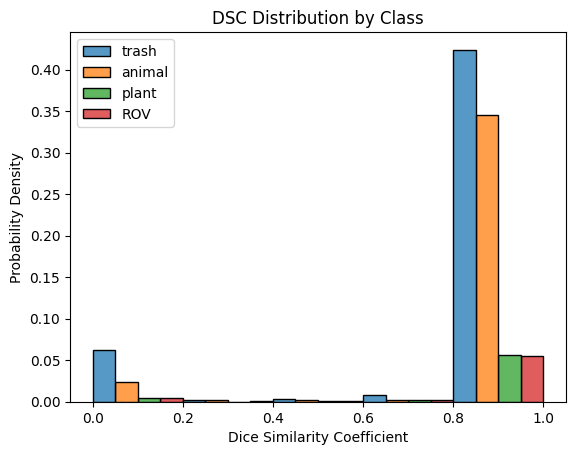

In [13]:
plt.figure()
sns.histplot(data=df, stat='probability', bins=5, multiple='dodge')
plt.xlabel('Dice Similarity Coefficient')
plt.ylabel('Probability Density')
plt.title('DSC Distribution by Class')
plt.savefig(os.path.join(results_path, 'hist1.png'))
plt.show()

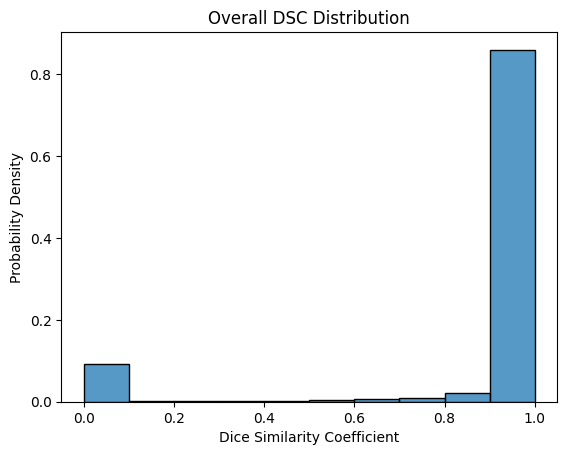

In [14]:
plt.figure()
sns.histplot(DSCs.flatten(), stat='probability', bins=10)
plt.xlabel('Dice Similarity Coefficient')
plt.ylabel('Probability Density')
plt.title('Overall DSC Distribution')
plt.savefig(os.path.join(results_path, 'hist2.png'))
plt.show()

In [15]:
cmap = matplotlib.colors.ListedColormap([[0, 0, 0],  # Background
                                         [0.88235294, 0.36078431, 0.36862745],  # Class 1
                                         [0.39215686, 0.71764706, 0.40392157],  # Class 2
                                         [1, 0.61568627, 0.32156863],  # Class 3
                                         [0.3254902, 0.60784314, 0.76862745]])  # Class 4

In [2]:
for k in range(Y_val.shape[0]):
  # Save the original image
  fig = plt.figure(frameon=False)
  fig.set_size_inches(16, 9)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(X_val[k, :, :, :], aspect='auto')
  fname = str(k).zfill(4) + '_image.png'
  fig.savefig(os.path.join(segmented_images_path, fname), bbox_inches='tight', pad_inches=0)

  # Save the ground truth mask
  fig = plt.figure(frameon=False)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(Y_val[k, :, :], cmap=cmap, interpolation='nearest', aspect='auto')
  fname = str(k).zfill(4) + '_mask_gt.png'
  fig.savefig(os.path.join(segmented_images_path, fname), bbox_inches='tight', pad_inches=0)

  # Save the predicted mask
  fig = plt.figure(frameon=False)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(Y_pred[k, :, :], cmap=cmap, interpolation='nearest', aspect='auto')
  fname = str(k).zfill(4) + '_mask_pred.png'
  fig.savefig(os.path.join(segmented_images_path, fname), bbox_inches='tight', pad_inches=0)
  plt.close('all')